In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

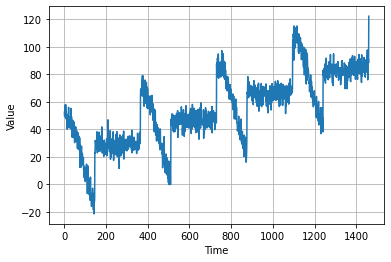

In [3]:
plot_series(time, series)

In [4]:
def window_data_gen(series, window_size, batch_size, shuffle_buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer_size).map(lambda x: (x[:window_size], x[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [28]:
dataset = window_data_gen(x_train, window_size, batch_size=128, shuffle_buffer_size=shuffle_buffer_size)

In [29]:
model = tf.keras.Sequential([
                             tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                             # tf.expand_dims will make the input data dimenstion as (None, None, 1) => (batchsize, timeseries_data_size, no of units) => 
                             #  Here as there is only one unit the last one will be 1 and timeseries_data_size will depend on the length of the data
                             tf.keras.layers.SimpleRNN(40),
                             tf.keras.layers.Dense(1),
                             tf.keras.layers.Lambda(lambda x: x*100)
])

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
    metrics=["mae"]
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_13 (Lambda)           (None, None, 1)           0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 40)                1680      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 41        
_________________________________________________________________
lambda_14 (Lambda)           (None, 1)                 0         
Total params: 1,721
Trainable params: 1,721
Non-trainable params: 0
_________________________________________________________________


In [30]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20)
)

In [33]:
history = model.fit(dataset, epochs=100, verbose=1, callbacks=[lr_callback])

Epoch 1/100
8/8 [==============================] - 1s 9ms/step - loss: 275.3770 - mae: 275.8770
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 274.7756 - mae: 275.2756
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 273.7659 - mae: 274.2658
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 272.4374 - mae: 272.9374
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 270.7570 - mae: 271.2570
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 268.6845 - mae: 269.1845
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 266.0986 - mae: 266.5986
Epoch 8/100
8/8 [==============================] - 0s 7ms/step - loss: 262.8681 - mae: 263.3681
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 258.9276 - mae: 259.4276
Epoch 10/100
8/8 [==============================] - 0s 8ms/step - loss: 254.2034 - mae: 254.7034
Epoch 11/100
8/8 [====================

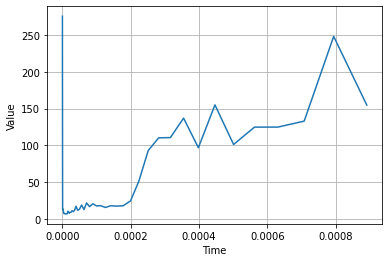

In [43]:
epochs = np.arange(100)
epochs = 1e-8 * 10 ** (epochs/20)

plot_series(history.history["lr"], history.history["loss"])

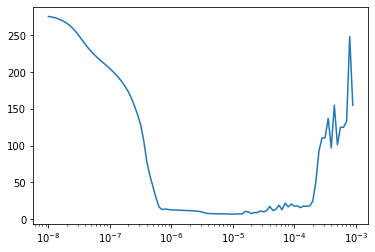

In [44]:
plt.semilogx(epochs, history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 30])

(1e-08, 0.0001, 0.0, 30.0)

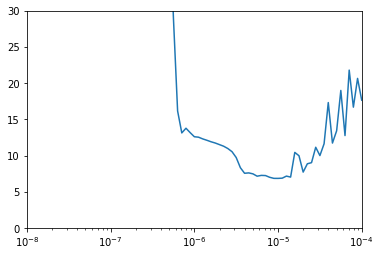

In [46]:
plt.semilogx(epochs, history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [47]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
                             tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                             # tf.expand_dims will make the input data dimenstion as (None, None, 1) => (batchsize, timeseries_data_size, no of units) => 
                             #  Here as there is only one unit the last one will be 1 and timeseries_data_size will depend on the length of the data
                             tf.keras.layers.SimpleRNN(40),
                             tf.keras.layers.Dense(1),
                             tf.keras.layers.Lambda(lambda x: x*100)
])

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
    metrics=["mae"]
)

history = model.fit(dataset, epochs=400, verbose=1)


Epoch 1/400
8/8 [==============================] - 1s 7ms/step - loss: 35.2969 - mae: 35.7933
Epoch 2/400
8/8 [==============================] - 0s 7ms/step - loss: 35.2082 - mae: 35.7046
Epoch 3/400
8/8 [==============================] - 0s 6ms/step - loss: 35.0800 - mae: 35.5760
Epoch 4/400
8/8 [==============================] - 0s 6ms/step - loss: 34.9298 - mae: 35.4239
Epoch 5/400
8/8 [==============================] - 0s 7ms/step - loss: 34.7763 - mae: 35.2698
Epoch 6/400
8/8 [==============================] - 0s 8ms/step - loss: 34.6179 - mae: 35.1120
Epoch 7/400
8/8 [==============================] - 0s 6ms/step - loss: 34.4658 - mae: 34.9610
Epoch 8/400
8/8 [==============================] - 0s 6ms/step - loss: 34.3098 - mae: 34.8053
Epoch 9/400
8/8 [==============================] - 0s 7ms/step - loss: 34.1617 - mae: 34.6570
Epoch 10/400
8/8 [==============================] - 0s 6ms/step - loss: 34.0067 - mae: 34.5012
Epoch 11/400
8/8 [==============================] - 0s 9ms/

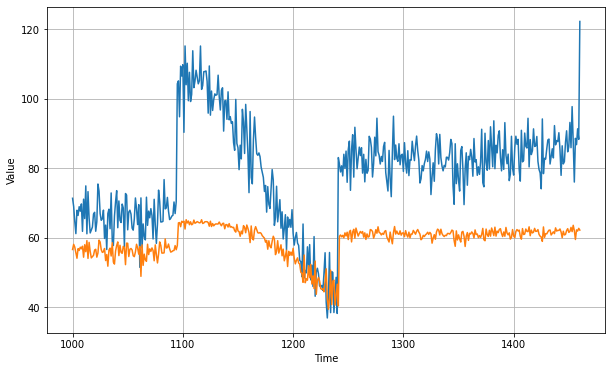

In [48]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [49]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

19.774841

<Figure size 432x288 with 0 Axes>

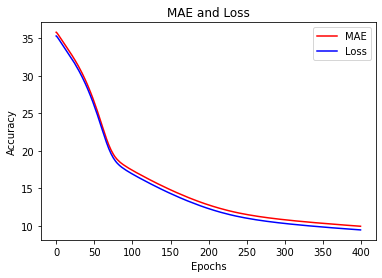

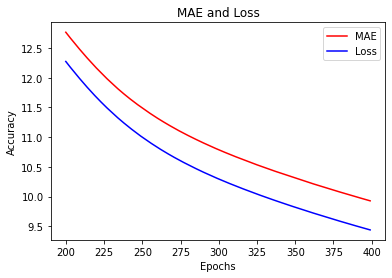

<Figure size 432x288 with 0 Axes>

In [50]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()